### Historical Performance Evaluation 
This notebook evaluates daily DCL price predictions using the frcast package, which implements an XGBoost Regressor.
Given the strong temporal dependence of DCL prices (notably a lag of 6 periods), a naive forecast using the previous day’s values is used as a baseline for comparison.

#### Section I – Daily Prediction Workflow
For each date in the evaluation period, the following steps are executed:
- **Data Preparation:** Retrieve one year of historical data preceding the prediction date.
- **Train–Validation Split:** Split the data into training and validation sets in a 75/25 ratio
(approximately 9 months for training, 3 months for validation).
- **Model Training and Forecasting:** Use Optuna to tune hyperparameters via time series cross-validation.
Train the best XGBoost model on the full year of data and generate forecasts for the next day.
- **Actual and Naive Data Collection:** Fetch actual DCL prices and auctioned prices for the prediction day and previous day via the NESO API. The previous day's auctioned price is used as the seasonal-naive forecast.

This process is repeated daily across the defined evaluation window.

#### Section II – Long-Term Performance Analysis
- **Data Aggregation:** Forecasted (XGB and naive) and actual DCL prices are stored for the period January–May 2025.
- **Metric Calculation:** Compute and visualize the mean absolute error (MAE) for: the full evaluation period
and each individual month
- **Model Comparison:** Compare XGBoost-predicted values against actual prices. Evaluate the performance of the naive approach as a baseline.

In [ ]:
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import frcast

#### Section I: Daily prediction

In [ ]:
# Define start and end dates
start_date, end_date = '2025-01-01', '2025-01-02'

In [ ]:
efa_index = frcast.get_efa_index(pd.Timestamp(start_date), pd.Timestamp(end_date))
# To store predicted, naive forecast, and actual values
target_df = pd.DataFrame(columns = ['pred',  'naive', 'actual',], index = efa_index)
# Predictions between start and end dates (inclusive)
dates = pd.date_range(start = start_date, end = end_date, freq = '1D')
for prediction_date in dates:
    prediction_date = prediction_date.strftime('%Y-%m-%d')
    prediciton_date_efa_index = frcast.get_efa_index(pd.Timestamp(prediction_date), 
                                                     pd.Timestamp(prediction_date))
    # Getting X, y for one-year before prediction date
    X, y = frcast.get_train_features_target_df(prediction_date)
    # Spliting into train (9 months data) and validation set (3 months data)
    splits = frcast.generate_time_series_splits(X,y, n_splits=3, test_size = 3*30*6)
    # Hyperparameters tuning
    optuna_study = frcast.run_xgb_optuna_tuning(X, y, n_trials=50)
    # Fitting the best model for one-year data
    best_model = frcast.train_final_xgb_model_from_study(X, y, optuna_study)
    # Features for the prediction date
    X_pred = frcast.get_prediction_features_df(prediction_date)
    # Prediction from the best model
    y_pred = best_model.predict(X_pred)
    # Auctioned price for the prediction date (available for the past)
    if(pd.Timestamp(prediction_date) <= pd.Timestamp.now().normalize()):
        y = frcast.get_historical_fr_price(prediction_date, prediction_date)
        y_actual = y['dcl_price'].values
    else:
        y_actual = pd.Series(index = X_pred.index) 
    # Seasonal naive-forecast (one day before)
    day_before_prediction_date = pd.Timestamp(prediction_date) - pd.Timedelta(days = 1)
    previous_day_df = frcast.get_historical_fr_price(day_before_prediction_date, day_before_prediction_date)
    previous_day_values = previous_day_df['dcl_price'].values
    # Storing the values
    target_df.loc[prediciton_date_efa_index, 'actual'] = y_actual
    target_df.loc[prediciton_date_efa_index, 'pred'] = y_pred
    target_df.loc[prediciton_date_efa_index, 'naive'] = previous_day_values

naive_error = mean_absolute_error(target_df['actual'], target_df['naive'])
xgb_error = mean_absolute_error(target_df['actual'], target_df['pred'])
print('For the period from', start_date, ' to', end_date, 'mean absolute errors are:')
print('Seasonal-naive forecast:', naive_error.round(2))
print('XGB regressor:', xgb_error.round(2))

#### Section II: Long-term performance analysis

In [46]:
df = pd.read_csv('./results/2025_all.csv')
df.rename(columns = {'Unnamed: 0': 'datetime',
                     'pred': 'xgb',
                     }, inplace = True)
df.set_index('datetime', drop = True, inplace = True)
df.index = pd.to_datetime(df.index, format = '%d/%m/%Y %H:%M')

In [48]:
naive_error = mean_absolute_error(df['actual'], df['naive']).round(2)
xgb_error = mean_absolute_error(df['actual'], df['xgb']).round(2)
print('For the period from', df.index[1].date(), ' to', df.index[-1].date(), 'mean absolute errors are:')
print('Naive:', naive_error)
print('XGB:', xgb_error)

For the period from 2025-01-01  to 2025-05-31 mean absolute errors are:
Naive: 2.1
XGB: 1.0


##### Comparison of XGBoost to Actual Prices

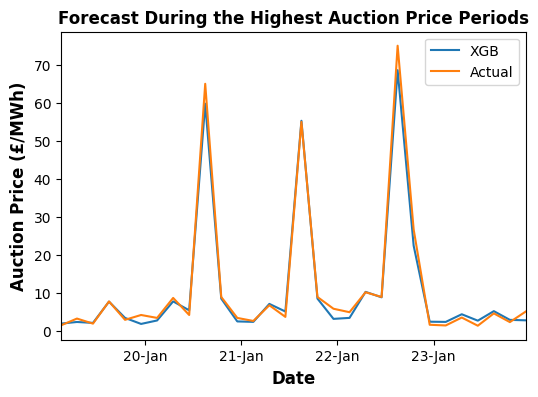

In [74]:
# Plotting the figure for short-duration
start_date = '2025-01-19'
end_date = '2025-01-24'
start_date = pd.Timestamp(start_date)
end_date = pd.Timestamp(end_date)
short_period_df = df[(df.index >= start_date)
                     &(df.index <= end_date)].copy()
fig, ax = plt.subplots(1, 1, figsize = (6,4))
# Plot manually using ax
ax.plot(short_period_df.index, short_period_df['xgb'], label='XGB')
ax.plot(short_period_df.index, short_period_df['actual'], label='Actual')
# Add legend
ax.legend()
# Format axis with 1 label per day
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'));

# Set correct axis limits
ax.set_xlim(short_period_df.index.min(), short_period_df.index.max())

# Axis labels
ax.set_xlabel('Date', fontweight = 'bold', fontsize = 12)
ax.set_ylabel('Auction Price (£/MWh)', fontweight = 'bold', fontsize = 12);
ax.set_title('Forecast During the Highest Auction Price Periods', fontsize=12, fontweight='bold');

#### Calculation of Monthly MAE (2025)

In [80]:
# finding the monthly mean error
monthly_error = pd.DataFrame(columns = ['XGBoost', 'Seasonal-naive'])
for month in [1, 2, 3, 4, 5]:
    month_start_date = pd.Timestamp(year = 2025, month = month, day = 1)
    next_month_start_date = pd.Timestamp(year = 2025, month = month+1, day = 1)
    month_df = df[(df.index >= month_start_date)
                  &(df.index <= next_month_start_date)]
    xgb_error = mean_absolute_error(month_df.xgb, month_df.actual).round(2)
    naive_error = mean_absolute_error(month_df.naive, month_df.actual).round(2)
    monthly_error.loc[month, :] = xgb_error, naive_error
    print(month, xgb_error, naive_error)

1 0.84 3.97
2 1.01 1.83
3 1.2 1.74
4 1.05 1.59
5 0.91 1.34


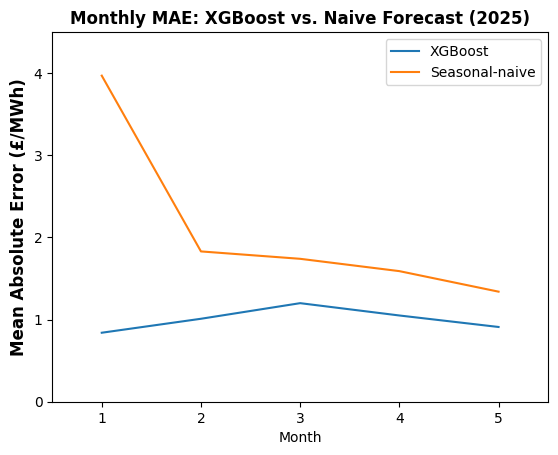

In [81]:
monthly_error.plot()
plt.xlim([0.5, 5.5]);
plt.xlabel('Month');
plt.ylabel('Mean Absolute Error (£/MWh)', fontsize = 12, fontweight = 'bold');
plt.ylim([0,4.5]);
plt.yticks([0, 1, 2, 3, 4]);
plt.title('Monthly MAE: XGBoost vs. Naive Forecast (2025)', fontsize = 12, fontweight = 'bold');